In [1]:
import os
import glob
import pandas as pd  # as means that we use pandas library short form  as pd
import cv2
import numpy as np
import matplotlib
import skimage 
import sklearn
from matplotlib import pyplot as plt # matplotlib is big library, we are just calling pyplot function 
                                    # for showing images
from skimage.feature import hog #We are calling only hog  

from sklearn.decomposition import PCA # Calling the PCA funtion from sklearn
from sklearn.svm import SVC # # Calling the SVM function from sklearn
from sklearn.externals import joblib # Calling the joblib function from sklearn, use for model saving 
                                     # and loading.

c:\users\piter\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
print ('Pandas Version: ',pd.__version__)
print ('OpenCv Version: ',cv2.__version__)
print ('Numpy Version: ',np.__version__)
print ('Matplotlib Version: ',matplotlib.__version__)
print ('skimage Version: ',skimage.__version__)
print ('sklearn Version: ',sklearn.__version__)

Pandas Version:  0.24.2
OpenCv Version:  4.1.2
Numpy Version:  1.16.3
Matplotlib Version:  3.1.2
skimage Version:  0.16.2
sklearn Version:  0.22.1


In [3]:
def load_paths(directory):
    paths = []
    for files in os.listdir(directory):
        paths.append(directory+'/'+files)
    return paths

In [4]:
def images_to_hog(directory): # function defining that can be call for both test and training
    paths = load_paths(directory)
    Features=[]
    Labels=[]
    imgs = []
    for path in paths:
        img_paths = load_paths(path)
        label = path.split("/")[-1]      
        for img_path in img_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.medianBlur(img, 3)
            img = cv2.resize(img, (64, 64))
            ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
            imgs.append(img)
            discripter = hog(img, orientations=8, pixels_per_cell=(4,4))         
            Features.append(discripter)
            Labels.append(label)
    Labels=np.array(Labels)
    return Features,Labels, imgs

In [5]:
directory = 'dataset/training_set'
Features_Training,Labels_Training,imgs = images_to_hog(directory)


In [6]:
# for img in imgs:
#     cv2.imshow("ss", img)
#     cv2.waitKey(0)

In [7]:
# print ('Training HOG output Features shape : ',Features_Training.shape)
# print ('Training HOG output Labels shape: ',Labels_Training.shape)

In [6]:
Test_Images_Directory='dataset/test_set'
Features_Testing,Labels_Testing, ttt = images_to_hog(Test_Images_Directory)

# for img in ttt:
#     cv2.imshow("ss", img)
#     cv2.waitKey(0)

In [7]:
print (len(Features_Testing))

270


In [8]:
pca = PCA(n_components = 40)
X_train = pca.fit_transform(Features_Training)
X_test = pca.transform(Features_Testing)

print ('New Train Dataset shape after PCA: ',X_train.shape)
print ('New Test Dataset shape after PCA: ',X_test.shape)

New Train Dataset shape after PCA:  (702, 40)
New Test Dataset shape after PCA:  (270, 40)


In [10]:
classifier=SVC(kernel='rbf',gamma='scale') # Calling the function SVC to implement SVM
classifier.fit(X_train,Labels_Training) # Training the Classifier on Train date

print ('SVM Mean Accuracy of Training dataset: ',classifier.score(X_train,Labels_Training))
print ('SVM Mean Accuracy of Test dataset: ',classifier.score(X_test,Labels_Testing))

SVM Mean Accuracy of Training dataset:  0.9401709401709402
SVM Mean Accuracy of Test dataset:  0.9407407407407408


In [11]:
joblib.dump(pca, 'pca_and_svm/pca_40.pkl') # joblib.dump Persist an arbitrary Python object into one file
joblib.dump(classifier, 'pca_and_svm/svm_rbf_scale.pkl') 

['pca_and_svm/svm_rbf_scale.pkl']

In [13]:
pca = joblib.load('pca_and_svm/pca_40.pkl')
classifier = joblib.load('pca_and_svm/svm_rbf_scale.pkl')

image_number=100

Reading Image from Path:  image_and_video/0.jpg


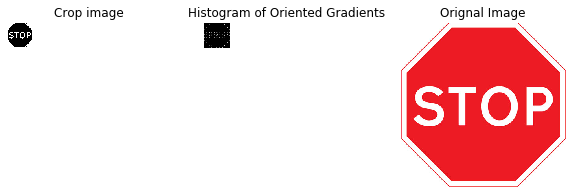

Predicted Class:  STOP


<Figure size 432x288 with 0 Axes>

In [14]:
from skimage.exposure import exposure #for displaying th hog image.

img_path='image_and_video/0.jpg'
print ('Reading Image from Path: ',img_path)
img = cv2.imread(img_path)
img0=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img0 = cv2.medianBlur(img0,3)

crop_image0=cv2.resize(img0, (64, 64))

# Apply Hog from skimage library it takes image as crop image.Number of orientation bins that gradient
# need to calculate.
ret,crop_image0 = cv2.threshold(crop_image0,127,255,cv2.THRESH_BINARY)
descriptor,imagehog  = hog(crop_image0, orientations=8,pixels_per_cell=(4,4),visualize=True)


# descriptor,imagehog = hog(crop_image0, orientations=8, visualize=True)
descriptor_pca=pca.transform(descriptor.reshape(1,-1))

# Initilize the 3 axis so that we can plot side by side
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10, 10), sharex=True, sharey=True)

#ploting crop image
ax1.axis('off')
ax1.imshow(cv2.cvtColor(crop_image0,cv2.COLOR_BGR2RGB), cmap=plt.cm.gray)
ax1.set_title('Crop image')

# Rescale histogram for better display,Return image after stretching or shrinking its intensity levels
hog_image_rescaled = exposure.rescale_intensity(imagehog, in_range=(0, 10))
#ploting Hog image
ax2.axis('off')
ax2.imshow(imagehog, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
#ploting Orignal image
ax3.axis('off')
ax3.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB), cmap=plt.cm.gray)
ax3.set_title('Orignal Image')
plt.show()
# class predition of image using SVM
Predicted_Class=classifier.predict(descriptor_pca)[0]
print ('Predicted Class: ',Predicted_Class)

ground_truth_image=cv2.imread('classes_images/'+str(Predicted_Class)+'.png')

fig = plt.figure()
#plt.imshow(cv2.cvtColor(ground_truth_image,cv2.COLOR_BGR2RGB), cmap=plt.cm.gray)
fig.suptitle('Class Ground Truth Image')
plt.show()